# Lasso regression on old dataset

In [162]:
library(caret)
library(glmnet)
library(doMC)

Loading required package: lattice



The `clean_cancer_old.csv` dataset contains all the 16235 cancer cells. However, the number of genes is reduced to 14297. This is done by eliminating all columns with NaNs.  

In [8]:
rna_old <- read.csv(file = '/data/severs/clean_cancer_old.csv')

In [13]:
rownames(rna_old) <- rna_old$X

In [14]:
rna_old$X <- NULL

In [18]:
Y = rna_old$ESR1

The split is stratified on the expression of ESR1. However, this can be performed on patient level as well.

In [208]:
set.seed(2)
train.index <- createDataPartition(Y, p = .8, list = FALSE)

In [209]:
X = rna_old[, -match("ESR1", colnames(rna_old))]

In [214]:
X_train <- X[train.index,]

In [211]:
Y_train <- Y[train.index]

In [215]:
X_test <- X[-train.index,]

In [213]:
Y_test <- Y[-train.index]

The input is normalized (subtract mean, divide by std) on the training data which is used to normalize the test data.

In [216]:
normParam <- preProcess(X_train)

In [217]:
norm.X_train <- predict(normParam, X_train)

In [218]:
norm.X_test <- predict(normParam, X_test)

In [318]:
lambdas <- 10^seq (-0.5, -3, by = -.05)

In [220]:
registerDoMC(cores = 20)

In [255]:
set.seed(2)
cv_lasso  <- cv.glmnet(as.matrix(norm.X_train) , Y_train,
                       nfolds = 5, alpha = 1, lambda = lambdas,
                       type.measure = "deviance", parallel=TRUE)

In [307]:
prediction <- predict(cv_lasso, newx=as.matrix(norm.X_test))

In [308]:
pred <- data.frame(list(prediction, Y_test))

In [309]:
colnames(pred) <- c("prediction", "truth")

In [310]:
pred <- pred[order(pred$truth),]

In [311]:
r2score <- rsq(Y_test, prediction)
rmsescore <- rmse(Y_test, prediction)

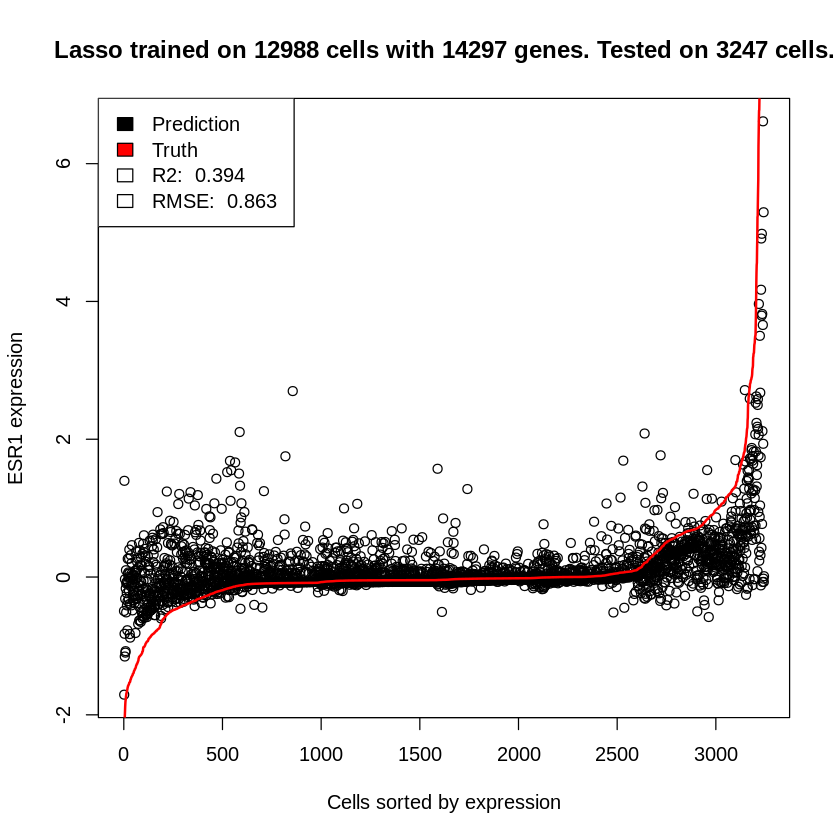

In [312]:
plot(pred$prediction, pch=1, ylab="ESR1 expression", xlab="Cells sorted by expression")
lines(pred$truth, col="red", lw=2)
legend("topleft", 
       legend=c("Prediction", "Truth",
                paste("R2: ", substr(toString(r2score), 1, 5)),
                paste("RMSE: ", substr(toString(rmsescore), 1, 5))),
       fill=c("black","red", "white", "white"))
title("Lasso trained on 12988 cells with 14297 genes. Tested on 3247 cells.")

In [313]:
rsq <- function (x, y) cor(x, y) ^ 2
rmse <- function (x, y) sqrt(mean((x-y)^2))

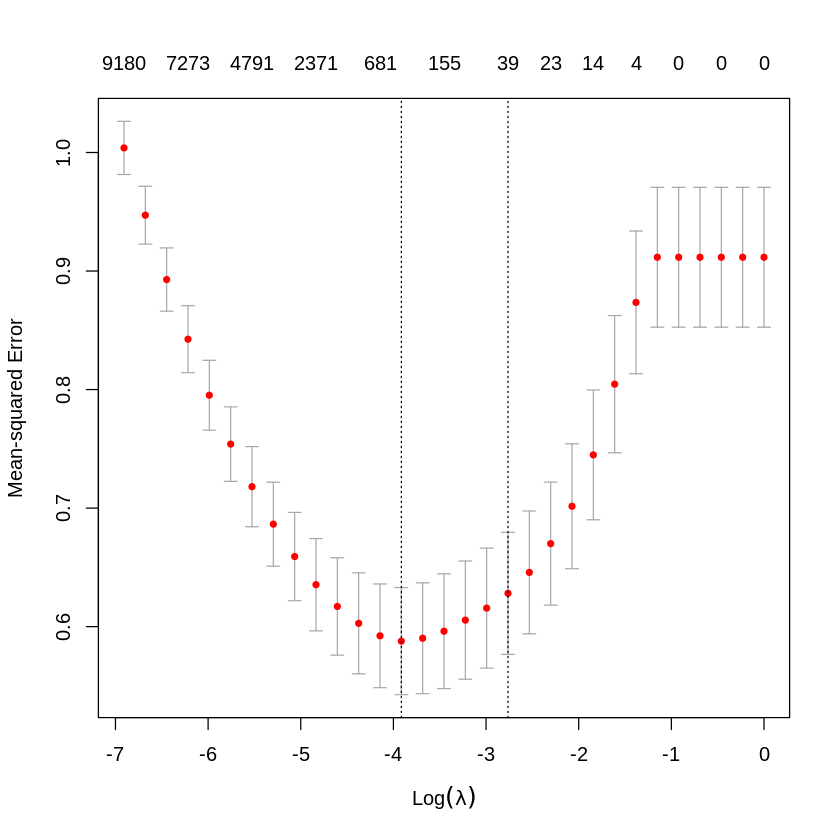

In [314]:
plot(cv_lasso)

In [397]:
sum(abs(coef(cv_lasso))>0)

[1] 40

In [411]:
lasso.mod <- glmnet(X_train, Y_train, alpha=1,  parallel=TRUE)

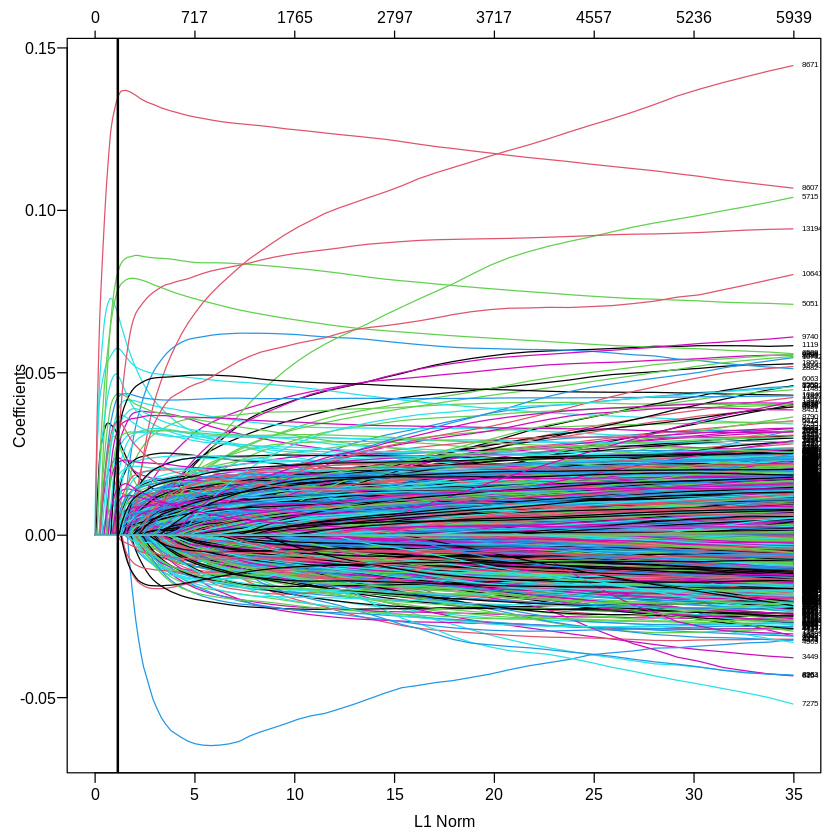

In [419]:
par(mfrow = c(1,1), mar = c(3.5,3.5,2,1), mgp = c(2, 0.6, 0), cex = 0.8, las = 1)
plot(lasso.mod, "norm", label = TRUE)
lines(c(sum(coef(cv_ridge)), sum(coef(cv_ridge))), c(-0.15, 0.25), col="black", lw=2)

In [437]:
biggest <- match(max(abs(coef(cv_ridge)[2:length(coef(cv_ridge))])),as.numeric(coef(cv_ridge)))

## Stratification on patient level with differentially expressed data

In [230]:
load("/data/xiaoral/rna_metadata.Rdata")

In [234]:
rownames(metadata.df) <- metadata.df$Cell

In [236]:
metadata.df$Cell <- NULL

In [367]:
set.seed(2)
train.index2 <- createDataPartition(metadata.df[metadata.df$CellType=="Cancer", ]$PatientNumber[abs(Y)>0.5], p = .8, list = FALSE)

In [368]:
X_train2 <- X[abs(Y)>0.5,][train.index2,]
Y_train2 <- Y[abs(Y)>0.5][train.index2]

In [369]:
X_test2 <- X[abs(Y)>0.5,][-train.index2,]
Y_test2 <- Y[abs(Y)>0.5][-train.index2]

In [370]:
# Scaling

normParam2 <- preProcess(X_train2)
X_train2 <- predict(normParam2, X_train2)
X_test2 <- predict(normParam2, X_test2)

In [371]:
lambdas2 <- 10^seq (0, -2.5, by = -.05)

In [372]:
set.seed(2)
cv_lasso2  <- cv.glmnet(as.matrix(X_train2) , Y_train2, nfolds = 5, alpha = 1, lambda = lambdas2 , type.measure = "deviance", parallel=TRUE)

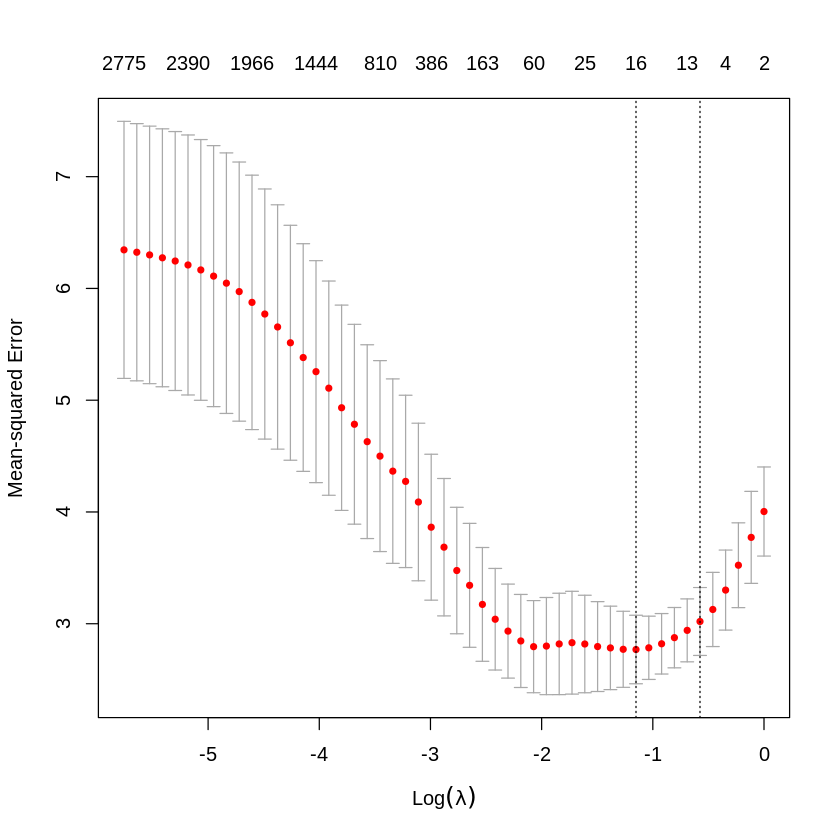

In [373]:
plot(cv_lasso2)

In [374]:
# Test on testset
prediction <- predict(cv_lasso2, newx=as.matrix(X_test2))
pred <- data.frame(list(prediction, Y_test2))
colnames(pred) <- c("prediction", "truth")
pred <- pred[order(pred$truth),]
r2score <- rsq(Y_test2, prediction)
rmsescore <- rmse(Y_test2, prediction)

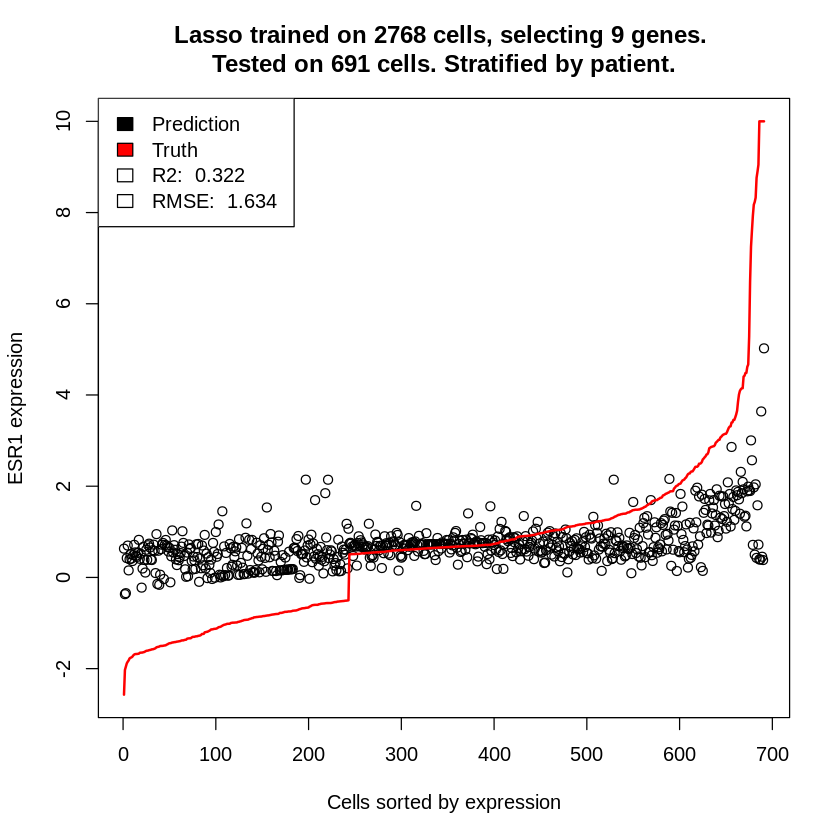

In [375]:
plot(pred$prediction, pch=1, ylab="ESR1 expression", xlab="Cells sorted by expression",
     ylim=c(min(c(min(pred$prediction), min(pred$truth))), max(c(max(pred$prediction), max(pred$truth)))))
lines(pred$truth, col="red", lw=2)
legend("topleft", 
       legend=c("Prediction", "Truth",
                paste("R2: ", substr(toString(r2score), 1, 5)),
                paste("RMSE: ", substr(toString(rmsescore), 1, 5))),
       fill=c("black","red", "white", "white"))
title("Lasso trained on 2768 cells, selecting 9 genes. \nTested on 691 cells. Stratified by patient.")

In [359]:
sum(abs(coef(cv_lasso2, s = "lambda.1se"))>0)

[1] 9

## Stratification on patient level with all data

In [376]:
set.seed(2)
train.index3 <- createDataPartition(metadata.df[metadata.df$CellType=="Cancer", ]$PatientNumber, p = .8, list = FALSE)

In [383]:
X_train3 <- X[train.index3,]
Y_train3 <- Y[train.index3]

In [384]:
X_test3 <- X[-train.index3,]
Y_test3 <- Y[-train.index3]

In [385]:
# Scaling

normParam3 <- preProcess(X_train3)
X_train3 <- predict(normParam2, X_train3)
X_test3 <- predict(normParam2, X_test3)

In [392]:
lambdas3 <- 10^seq (0.5, -3, by = -.05)

In [393]:
set.seed(2)
cv_lasso3  <- cv.glmnet(as.matrix(X_train3) , Y_train3,
                        nfolds = 5, alpha = 1, lambda = lambdas3 ,
                        type.measure = "deviance", parallel=TRUE)

In [445]:
sum(abs(coef(cv_ridge3))>0)

[1] 59

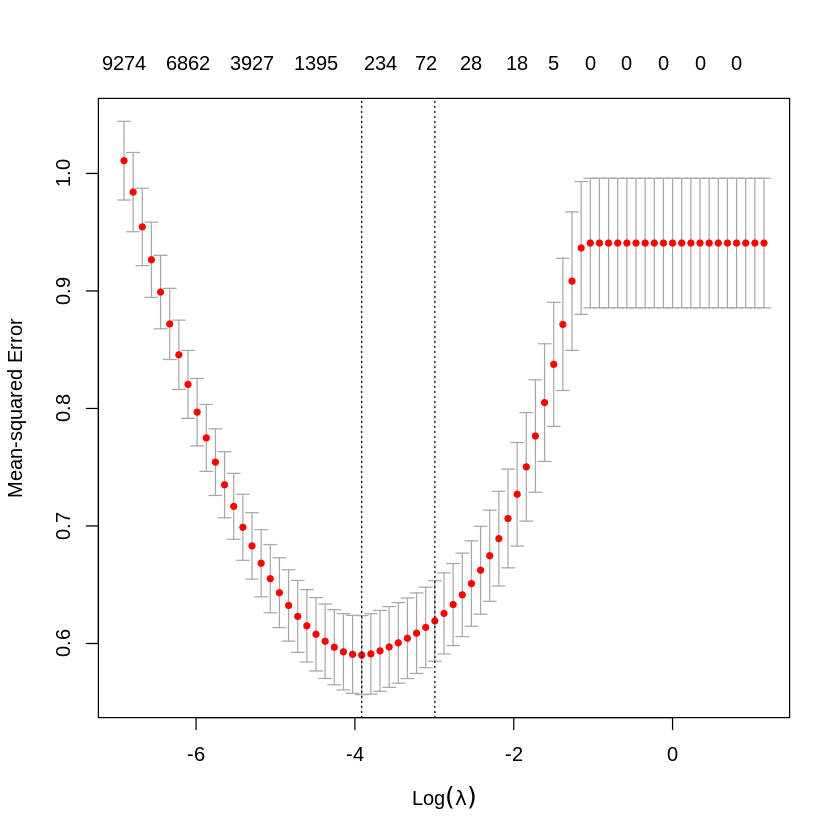

In [394]:
plot(cv_lasso3)

In [395]:
nrow(X_train3)

[1] 12990

In [390]:
# Test on testset
prediction <- predict(cv_lasso3, newx=as.matrix(X_test3))
pred <- data.frame(list(prediction, Y_test3))
colnames(pred) <- c("prediction", "truth")
pred <- pred[order(pred$truth),]
r2score <- rsq(Y_test3, prediction)
rmsescore <- rmse(Y_test3, prediction)

In [448]:
getwd()

[1] "/home/severs/SingleCells/notebooks/src"

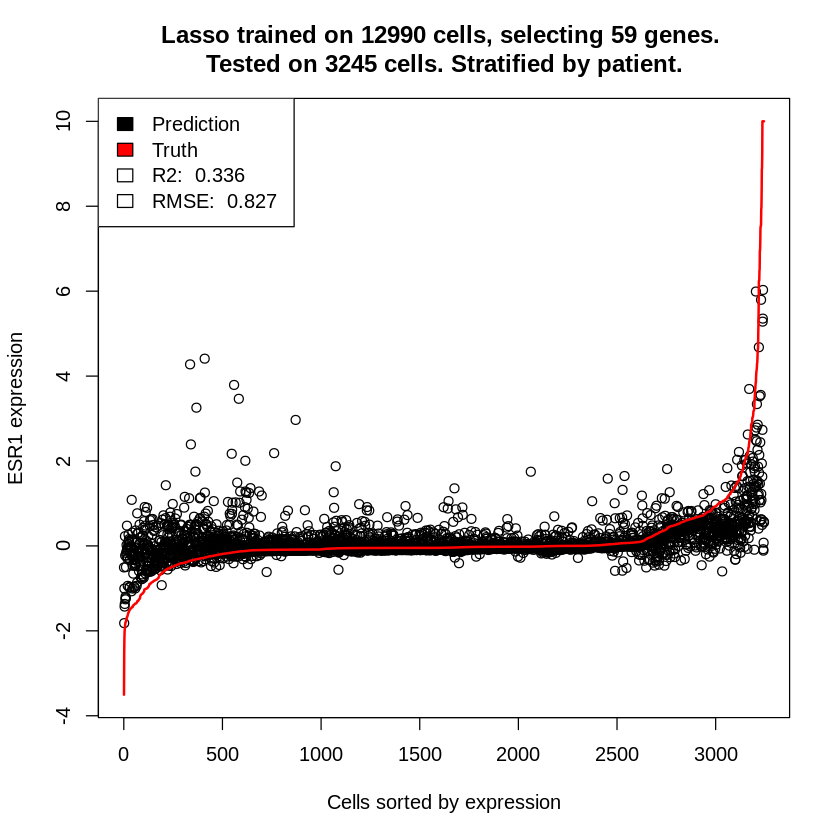

In [450]:
#pdf("/home/severs/SingleCells/plots/lasso_patient_strat.pdf")
plot(pred$prediction, pch=1, ylab="ESR1 expression", xlab="Cells sorted by expression",
     ylim=c(min(c(min(pred$prediction), min(pred$truth))), max(c(max(pred$prediction), max(pred$truth)))))
lines(pred$truth, col="red", lw=2)
legend("topleft", 
       legend=c("Prediction", "Truth",
                paste("R2: ", substr(toString(r2score), 1, 5)),
                paste("RMSE: ", substr(toString(rmsescore), 1, 5))),
       fill=c("black","red", "white", "white"))
title("Lasso trained on 12990 cells, selecting 59 genes. \nTested on 3245 cells. Stratified by patient.")
#dev.off()

# Analysis of NeoLetExe metadata

In [3]:
library("Seurat")

In [4]:
load("/data/severs/NeoLetExe_five_triplets.RData")

In [88]:
library("ggplot2")

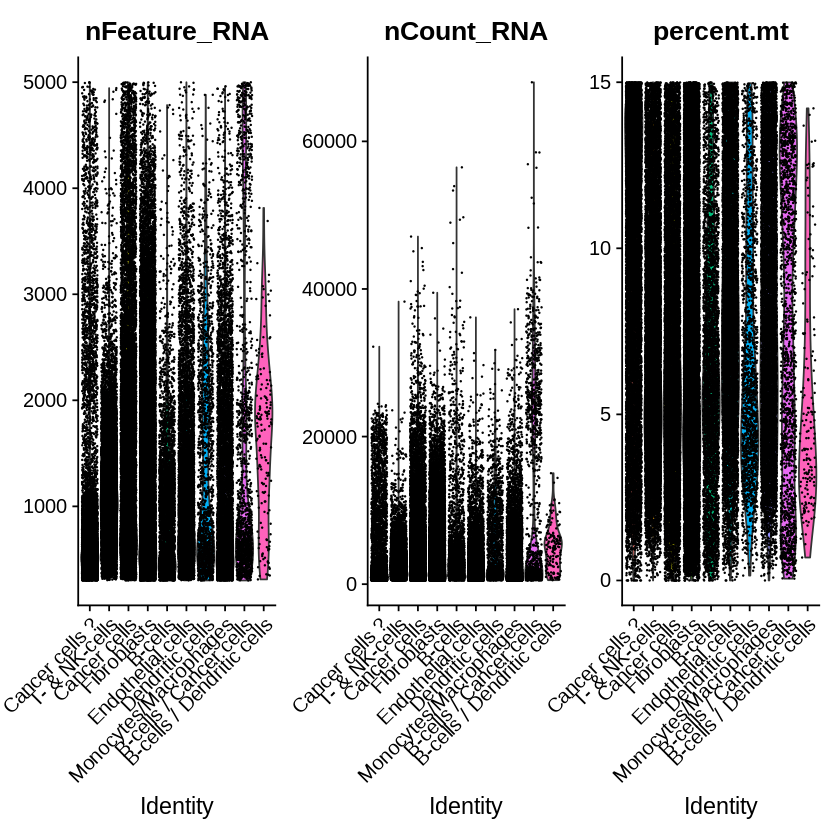

In [5]:
VlnPlot(Subset_Cells, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

In [6]:
Subset_Cells

An object of class Seurat 
33562 features across 94231 samples within 1 assay 
Active assay: RNA (33562 features, 0 variable features)
 2 dimensional reductions calculated: pca, umap

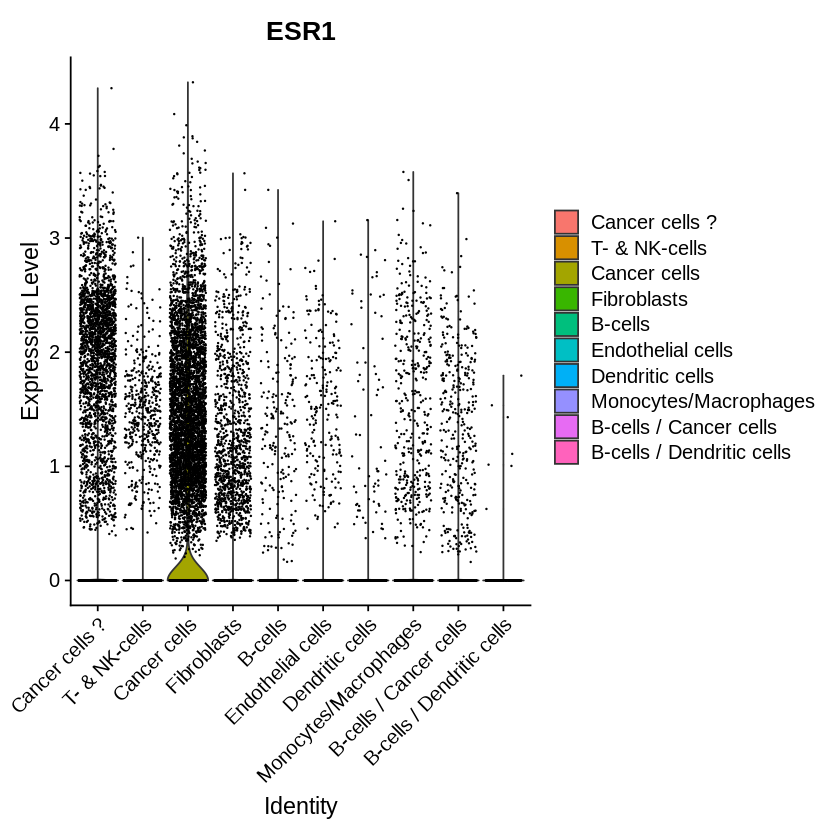

In [7]:
VlnPlot(object = Subset_Cells, features = c("ESR1"))

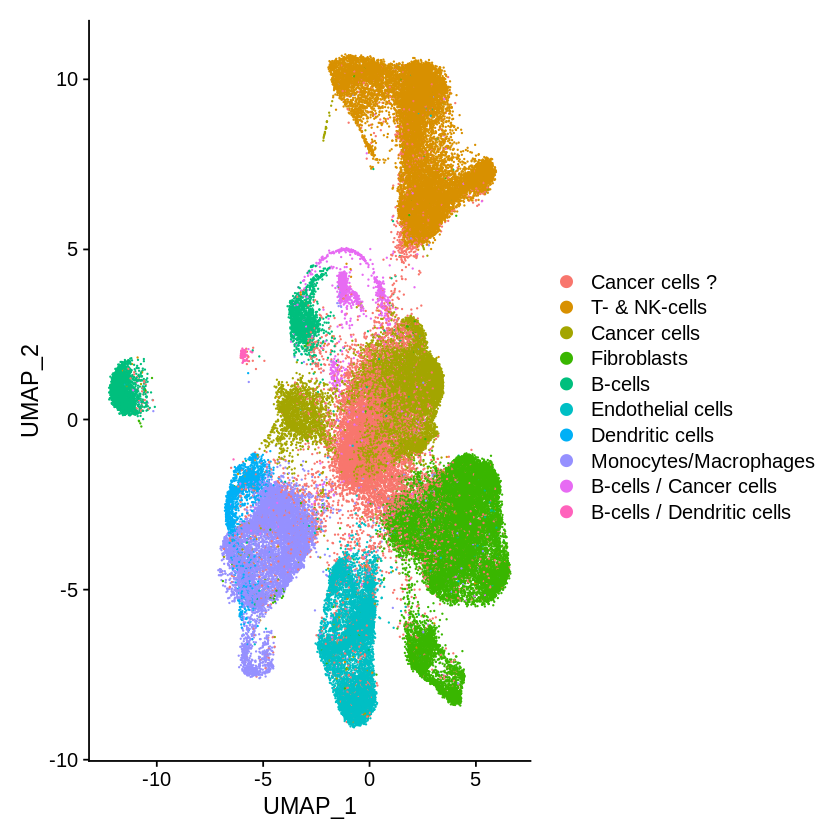

In [13]:
DimPlot(Subset_Cells)

In [6]:
meta_data <- data.frame(Subset_Cells@meta.data)

In [43]:

DimPlot(Subset_Cells, dims=c(1,2), reduction = "umap",label=TRUE)

#ggsave("/home/severs/SingleCells/plots/umap.png", height = 7 , width = 7 * 2)

ERROR: Error in value[[3L]](cond): could not open file '/tmp/RtmpfhtqBk/file8a3d78f412ff.png'


plot without title

In [10]:
UMAP_coord <- as.data.frame(Subset_Cells[["umap"]]@cell.embeddings)

In [11]:
UMAP_coord["patient_number"] <- meta_data["patient_number"]

In [12]:
meta_data["UMAP_1"] <- UMAP_coord["UMAP_1"]
meta_data["UMAP_2"] <- UMAP_coord["UMAP_2"]

In [15]:
write.csv(meta_data, "/data/severs/NeoLet_metadata.csv", row.names=TRUE)